# Exercice 4 : Détection d’Anomalies (Fraude Bancaire)

**Objectif :** Identifier des comportements suspects sans avoir de labels "fraude".

* **Dataset :** **Credit Card Fraud Detection**.
* **Volume :** Inutile d'utiliser les 284 000 lignes. Un échantillon de **50 000 transactions normales** suffit amplement pour entraîner l'AE.
* **Méthode :** Entraînez l'AE **uniquement** sur des transactions valides.
* **Mesure de l'anomalie :** Calculez la **MSE (Mean Squared Error)** entre l'entrée et la sortie. Si le MSE est "fort" alors la transaction est marquée comme une anomalie (car le réseau n'a jamais appris à reconstruire ce type de profil).


In [84]:
# --- imput ---

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, models, datasets
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Rescaling, Reshape
from tensorflow.keras.layers import Conv1D, BatchNormalization, Flatten, Dense, GlobalAvgPool1D, Activation, MaxPool1D, UpSampling1D
from tensorflow.keras.layers import Conv2DTranspose


import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = "#2c2c2cff"
plt.rcParams['figure.facecolor'] = "#2c2c2cff"

In [94]:
try:
    df_fraud = pd.read_csv(r'datasets\creditcard.csv')
    
    # 1. On sépare les normales des fraudes
    df_normal = df_fraud[df_fraud['Class'] == 0].drop(['Class', 'Time'], axis=1)
    df_anomaly = df_fraud[df_fraud['Class'] == 1].drop(['Class', 'Time'], axis=1)
    
    # 2. Préparation de l'entraînement (Uniquement sur des transactions normales)
    # On prend 50 000 normales pour l'entraînement
    x_normal_train, x_normal_test = train_test_split(
        df_normal.sample(n=50000, random_state=42), 
        test_size=0.2, 
        random_state=42
    )
    
    # 3. Normalisation (On calibre le scaler sur le train normal UNIQUEMENT)
    scaler = StandardScaler()
    x_train_anomaly = scaler.fit_transform(x_normal_train)
    x_test_normal = scaler.transform(x_normal_test)
    
    # 4. Préparation du set de FRAUDES pour le test final
    # On normalise les fraudes avec le même scaler
    x_test_fraud = scaler.transform(df_anomaly)
    
    print(f"✅ Dataset chargé.")
    print(f"🏠 Transactions normales pour l'entraînement : {x_train_anomaly.shape[0]}")
    print(f"🚨 Transactions frauduleuses pour le test final : {x_test_fraud.shape[0]}")

except FileNotFoundError:
    print("⚠️ Fichier 'creditcard.csv' non trouvé.")

# --- RÉSUMÉ DES DIMENSIONS ---

print(f"📊 Anomaly (Fraud): {x_train_anomaly.shape if 'x_train_anomaly' in locals() else 'N/A'}")


✅ Dataset chargé.
🏠 Transactions normales pour l'entraînement : 40000
🚨 Transactions frauduleuses pour le test final : 492
📊 Anomaly (Fraud): (40000, 29)


In [86]:
x_train_anomaly.shape

(40000, 29)

In [87]:
# --- encoder modeling --- 

inp = Input(shape=(29, 1))

# Encoder
x = Conv1D(32, 3, padding="same", activation="relu")(inp)
x = BatchNormalization()(x)
x = MaxPool1D(2, padding="same")(x)   # 29 → 15

x = Conv1D(16, 3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)
encoded = MaxPool1D(2, padding="same")(x)  # 15 → 8

# Decoder
x = Conv1D(16, 3, padding="same", activation="relu")(encoded)
x = BatchNormalization()(x)
x = UpSampling1D(2)(x)  # 8 → 16

x = Conv1D(32, 3, padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = UpSampling1D(2)(x)  # 16 → 32

# Финальный Conv обрезает до 29
decoded = Conv1D(1, 3, padding="same")(x[:, :29, :])

model = Model(inp, decoded)
model.compile(optimizer="adam", loss="mse")

In [88]:
history = model.fit(
    x_train_anomaly, x_train_anomaly,
    epochs=150,
    batch_size=512,
    validation_split=0.1,
    shuffle=True

)

Epoch 1/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.9246 - val_loss: 0.8482
Epoch 2/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5068 - val_loss: 0.7136
Epoch 3/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3510 - val_loss: 0.5190
Epoch 4/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2644 - val_loss: 0.3512
Epoch 5/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2152 - val_loss: 0.2351
Epoch 6/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1833 - val_loss: 0.1754
Epoch 7/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1581 - val_loss: 0.1409
Epoch 8/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1413 - val_loss: 0.1263
Epoch 9/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1294 - val_loss: 0.1153
Epoch 10/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1222 - val_loss: 0.1084
Epoch 11/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1162 - val_loss: 0.1018
Epoch 12/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 

<Figure size 640x480 with 0 Axes>

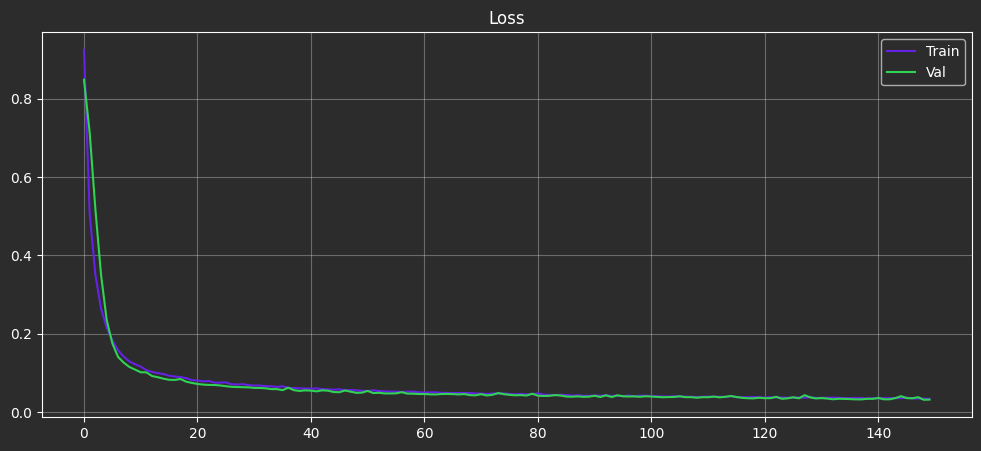

In [89]:
def show_results(history):
    fig, axes = plt.subplots(1, figsize=(12, 5))

    # Loss
    axes.plot(history.history['loss'], color="#6622e4", label='Train')
    axes.plot(history.history['val_loss'], color="#30d353", label='Val')
    axes.set_title('Loss')
    axes.grid(alpha=0.3)
    axes.legend()


plt.tight_layout()
plt.show()

show_results(history)

In [95]:
x_hat_normal = model.predict(x_test_normal)
x_hat_fraud = model.predict(x_test_fraud)

x_train = x_train_anomaly.reshape(-1, 29, 1)
x_test_normal = x_test_normal.reshape(-1, 29, 1)
x_test_fraud = x_test_fraud.reshape(-1, 29, 1)

err_normal = np.mean(
    np.square(x_test_normal - x_hat_normal),
    axis=(1, 2)
)

err_fraud = np.mean(
    np.square(x_test_fraud - x_hat_fraud),
    axis=(1, 2)
)

threshold = np.percentile(err_normal, 95)


y_true = np.concatenate([
    np.zeros(len(err_normal)),
    np.ones(len(err_fraud))
])

y_score = np.concatenate([
    err_normal,
    err_fraud
])

y_pred = (y_score > threshold).astype(int)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
from sklearn.metrics import roc_auc_score, classification_report

print("ROC-AUC:", roc_auc_score(y_true, y_score))
print(classification_report(y_true, y_pred))

ROC-AUC: 0.9548156504065041
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     10000
         1.0       0.46      0.86      0.60       492

    accuracy                           0.95     10492
   macro avg       0.73      0.91      0.78     10492
weighted avg       0.97      0.95      0.95     10492

